# Imports

In [1]:
import numpy as np
import pandas as pd

import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import datetime
import scipy as sp
import utm

# For a bigger output image
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Subsampling time-intervals:

In [2]:
def subsample_obs_time(df_in, time_interval_sec, obs_per_interval):

    obs = obs_per_interval
    time_inteval = time_interval_sec

    #Max and min time
    maxtime = max(df_in['datetimestamp'].values)
    mintime = min(df_in['datetimestamp'].values)

    #Total number of time sections in the data
    total_iter = int(maxtime/time_inteval) +1

    #start interval, inclusive
    lowerbound = mintime 
    #initial size, exclusive
    upperbound = time_inteval 

    #Result DATAFRAME
    df_sub_result = df_in.copy(deep = True)
    df_sub_result = df_sub_result.iloc[0:0] #drop all entries in the dataframe

    for subset_walk in np.arange(1,total_iter+2,1):#each subset present
        boolean_selection = ((lowerbound < df_in['datetimestamp']) & (df_in['datetimestamp'] <= upperbound)).values

        #subset for this interval
        time_subset = copy.deepcopy(df_in.iloc[boolean_selection,:])

        # subsampling the time sibset
        if obs < len(time_subset): #if the no of observations is lessthat the total in the timestep continue, else nothing
            for subsample in np.arange(0,len(time_subset), obs): #step with size = obs to sample each value in the set
                df_sub_result = df_sub_result.append(time_subset.iloc[subsample,:])

        #update bounds
        #start interval, inclusive
        lowerbound = copy.deepcopy(upperbound)
        upperbound = time_inteval*subset_walk

    return df_sub_result

## Other functions needed

In [3]:
def dataframe_stats (df_in):
    print("Length:",len(df_in['datetimestamp']))
    print("Total time:",max(df_in['datetimestamp']))
    print("Min Long:",min(df_in['long']))
    print("Max Long:",max(df_in['long']))
    print("Min lat:",min(df_in['lat']))
    print("Max lat:",max(df_in['lat']))

# Kalman - Conversions:

In [4]:
def convert_cog(data_in):
    return (data_in)*np.pi/180 #convert to radians

def convert_rot(data_in):
    return (data_in/60)*np.pi/180 #rad per second
    
def convert_sog(data_in):
    return data_in*0.5144444444 #meter per second

def convert_dataset(data_in, time_interval_sub, each_obs_sub):
    #Converting time date:
    df_sorted = copy.deepcopy(data_in.sort_values(by = 'datetimestamp', ascending = True ))
    #Getting the date of the first observation
    first_obs_date = df_sorted.iloc[0,6]

    #Subtracting the dates to get the seconds from start to finish
    df_sorted['datetimestamp'] = ((pd.to_datetime(df_sorted['datetimestamp']) - pd.to_datetime(first_obs_date)).dt.total_seconds())

    #Sub sample time interval in seconds, after dates has been converted to startin at 0 sec to 5000s (example)
    test = subsample_obs_time(df_sorted, time_interval_sub, each_obs_sub)
    df_sorted = copy.deepcopy(test)
    

    #Conversion of Course over ground
    df_sorted['cog'] = convert_cog(df_sorted['cog'])
    
    #Convert Speed over ground to mps
    df_sorted['sog'] = convert_sog(df_sorted['sog'])
    
    #Convert rate of turn 
    df_sorted['rot'] = convert_rot(df_sorted['rot'])
    
    #Making the order same as testset    
    df_sorted = df_sorted[['datetimestamp', 'lat', 'long', 'cog', 'sog','rot']]
    
    # Caluclating the the cartesian coordinates
    X = []
    Y = []
    
    #initial cartesian
    init_utm = utm.from_latlon(df_sorted['lat'].values[0], df_sorted['long'].values[0])
    X.append(init_utm[0])   #adding X coordinate
    Y.append(init_utm[1])   #Adding Y coordinate

    delta_time = [] #calculating delta time
    delta_time.append(0)
    for i in np.arange(1, len(df_sorted['datetimestamp']),1):
        delta_time.append(int(df_sorted['datetimestamp'].values[i]) - int(df_sorted['datetimestamp'].values[i-1]))
        #Caclulcating coordinates
        ans = utm.from_latlon(df_sorted['lat'].values[i], df_sorted['long'].values[i])
        #Adding the cartesian coordinates per time step
        X.append(copy.deepcopy(ans[0]))
        Y.append(copy.deepcopy(ans[1]))
    
   
    #Adding the delta time
    df_sorted.insert(1,'deltatime',delta_time) 
    #Adding cartesian coordiantes
    df_sorted['lat'] = Y
    df_sorted['long'] = X
   
    return df_sorted   

## Functions for the Kalman Filter

In [5]:
def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

def calc_a_xy(arr_in, arr_prev):
    
    sog_now = np.around(arr_in[5],8)
    sog_prev = np.around(arr_prev[5],8)
    
    cog_now = np.around(arr_in[4],8)
    cog_prev = np.around(arr_prev[4],8)
    
    rot_now = np.around(arr_in[6],6)    
    delta_time = arr_in[1]   
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y


def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]    
    x = arr_in[2]
    y = arr_in[3]        
    Vx = sog*np.cos(cog)
    Vy = sog*np.sin(cog)
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

def extract_long_lat_covariance(mat_in):
    Var1 = mat_in[0,0]
    Var2 = mat_in[1,1]
    Cov12 = mat_in[0,1]
    
    result = np.array([[Var1,Cov12],[Cov12,Var2]])
    return result

# The Kalman Filter:

In [65]:
ax_arr = []
ay_arr= []
Pk_save_states = []
def myKalman(pd_final, R,Q,P_k):
    global ax_arr, ay_arr, df_final,Pk_save_states
    
    H = np.identity(4)
    I = np.identity(4)   

    lat_AVG = np.average(pd_final['lat'].values[0:3])
    long_AVG = np.average(pd_final['long'].values[0:3])
    # Kalman Initial state
    X_state = np.array([[0],[0],[0],[0]])
    
    # Lists to append data and values to, saving ttansitions:
    ax_arr = []
    ay_arr = []
    X_save_states = []
    Pk_save_states = []
    Pk_save_states.append(copy.deepcopy(P_k))

    data_counter = 1 # counter for the original data set obsevations

    max_time = int(max(pd_final.iloc[:,0]))
    min_time = int(min(pd_final.iloc[:,0]))

    data_counter_stop = max_time-min_time
    
    realSpeedX = []
    realSpeedY = []
    realSpdCount = []
    for i in np.arange(0,max_time,1):

        '''If we observe the value we observe this'''
        if(i == 0 or (int(pd_final.iloc[data_counter,0]) == i and data_counter < data_counter_stop)):
            zk_prev = pd_final.iloc[data_counter-1,:].values #previous observation
            z_k = pd_final.iloc[data_counter,:].values # convert to numpy array -observed value

            delta_TIME = copy.deepcopy(z_k[1]) #difference in time
            A = get_mat_A(delta_TIME)

            #Acceleration
            ax, ay = calc_a_xy(z_k,zk_prev) 
            ax_arr.append(ax)
            ay_arr.append(ay)

            z_k = copy.deepcopy(convert_state(z_k)) #convert state
            realSpdCount.append(i)
            realSpeedX.append(z_k[2][0])
            realSpeedY.append(z_k[3][0])
            X_state = copy.deepcopy(convert_state(zk_prev))

            #Kalman Predict--------------------------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, delta_TIME))
            P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))

            #Kalman Measuremenet update--------------------------------------------------------------------------------
            Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
            X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
            P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))


            #increment counter
            data_counter += 1

            #Saving states
            X_save_states.append(copy.deepcopy(X_state))
            Pk_save_states.append(copy.deepcopy(P_k))

        else:
            '''This code will be excecuted when we have no observation'''
            ay = 0
            ax = 0
            A = get_mat_A(1)
            #Kalman Predict --------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
            P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))

            #Saving states
            Pk_save_states.append(copy.deepcopy(P_k))
            X_save_states.append(copy.deepcopy(X_state))



    # Saving the coordinates:
    X_coord = []
    Y_coord = []
    Pk_coord  = []
    SpeedX = []
    SpeedY = []
    

    for i in range(0,len(X_save_states)):
        if i > 1 and  i % 1 == 0:
            X_coord.append(X_save_states[i][0][0])
            Y_coord.append(X_save_states[i][1][0])
            SpeedX.append(X_save_states[i][2][0]) #Speed in X axis
            SpeedY.append(X_save_states[i][3][0]) #Speed in Y axis
            
            #Pk_coord.append(extract_long_lat_covariance(Pk_save_states[i]))

    #Extracting the original data:
    X_orig = copy.deepcopy(pd_final.iloc[:,2])
    Y_orig = copy.deepcopy(pd_final.iloc[:,3])

    #Graph outputs:
    '''Speed in the X-axis'''
    plt.plot(np.arange(0,len(SpeedX),1), SpeedX, 'b-')
    plt.plot(realSpdCount, realSpeedX,'r-')
    plt.title("Linear Speed in X")
    legend_data = ["Kalman","Original" ]
    plt.legend(legend_data,loc = 'best')
    plt.show()
    
    '''Speed in the Y-axis'''
    plt.plot(np.arange(0,len(SpeedY),1),SpeedY)
    plt.plot(realSpdCount, realSpeedY,'r-')
    legend_data = ["Kalman","Original" ]
    plt.legend(legend_data,loc = 'best')
    plt.title("Linear Speed in Y")    
    plt.show()
       
    '''X coordinate tracking'''
    plt.plot(realSpdCount,Y_orig[0:(len(realSpdCount))], "bo")
    plt.plot(np.arange(0,len(Y_coord),1),Y_coord, "r.")
    legend_data = ["Original","Kalman"]
    plt.legend(legend_data,loc = 'best')
    plt.title("X pred (red) vs original (blue)")
    plt.show()
    
    '''Y coordinate tracking'''
    plt.plot(realSpdCount,X_orig[0:(len(realSpdCount))], "bo")
    plt.plot(np.arange(0,len(X_coord),1),X_coord, "r.")
    plt.title("Y pred (red) vs original (blue)")
    legend_data = ["Original","Kalman"]
    plt.legend(legend_data,loc = 'best')
    plt.show()

    
    return np.array(X_coord),np.array(Y_coord),X_orig,Y_orig,ax_arr,ay_arr, SpeedX, SpeedY, np.array(realSpdCount)


# Importing dataset & getting linear trajectory:

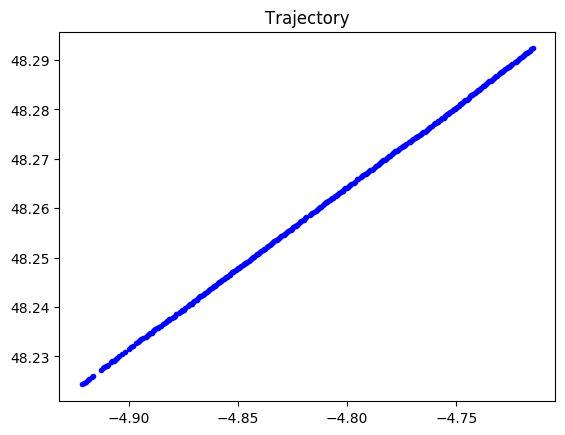

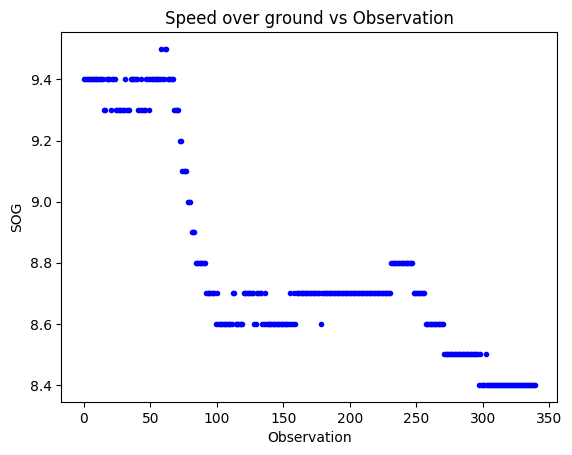

In [66]:
pd_dataset = None 
pd_dataset = pd.read_csv(r"538004506.csv")

#Boundaries sampling from and to
lower = 10
upper = 350

plt.plot(pd_dataset['long'].values[lower:upper],pd_dataset['lat'].values[lower:upper],'b.')
plt.title("Trajectory")
plt.show()

plt.plot(np.arange(0,len(pd_dataset['sog'].values[lower:upper]),1),pd_dataset['sog'].values[lower:upper],'b.')
plt.title("Speed over ground vs Observation")
plt.xlabel("Observation")
plt.ylabel("SOG")
plt.show()

# SUB SAMPLING & TRAJECTORY EXTRACTION

In [67]:
lower = 10
upper = 350
myrange = np.arange(lower,upper,1) #to cut the part thats goint to be used

pd_dataset_new = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,1)
#The pandas dataframe index needs to be resetted so that the indexing does'nt play a factor

### Trajectory statistics:

In [68]:
#Getting some stats on the extracted trajectory
dataframe_stats(pd_dataset_new)    

Length: 339
Total time: 3749.0000000000005
Min Long: 357377.9381440297
Max Long: 372795.4156094043
Min lat: 5343054.25996773
Max lat: 5350213.777297369


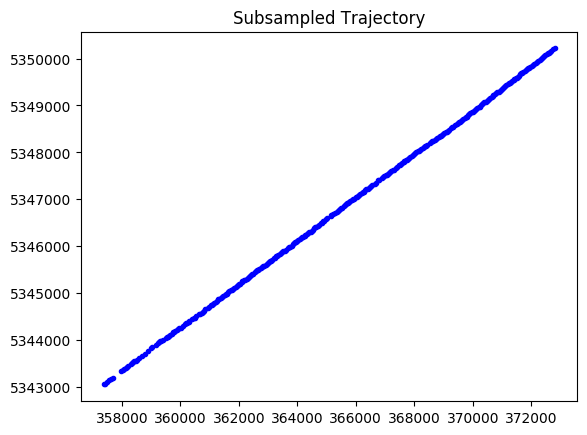

In [69]:
#Deepcopy the new dataset to the sampled one
df_sampled = copy.deepcopy(pd_dataset_new)

plt.plot(df_sampled['long'],df_sampled['lat'],'b.')
plt.title("Subsampled Trajectory")
plt.show()

# Setting up $P_k$

In [70]:
#IMO Standards
var_X = 10
var_Y = 10
var_spdX = 0.3
var_spdY = 0.3

P_k = np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]).dot(np.transpose(
      np.array([[var_X],[var_Y],[var_spdX],[var_spdY]])))

# Setting up $Q$:



In [71]:
# IMO standards:
var_X = 10
var_Y = 10
var_spdX = 0.3
var_spdY = 0.3

Q = np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]).dot(np.transpose(
      np.array([[var_X],[var_Y],[var_spdX],[var_spdY]]))) 

# Setting up R:


In [72]:
R = np.diag(np.diag(P_k))

# Running the Kalman filter

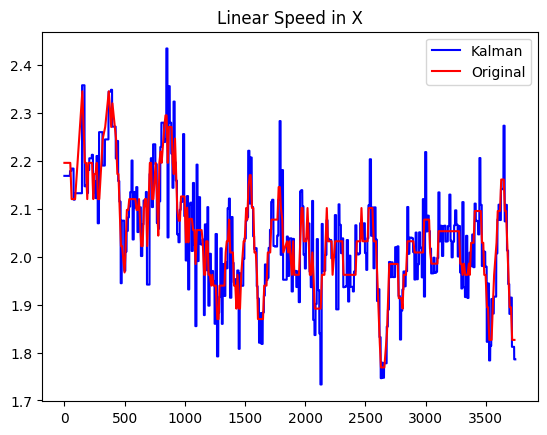

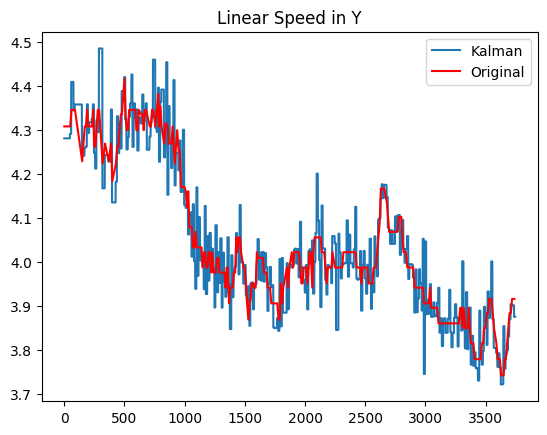

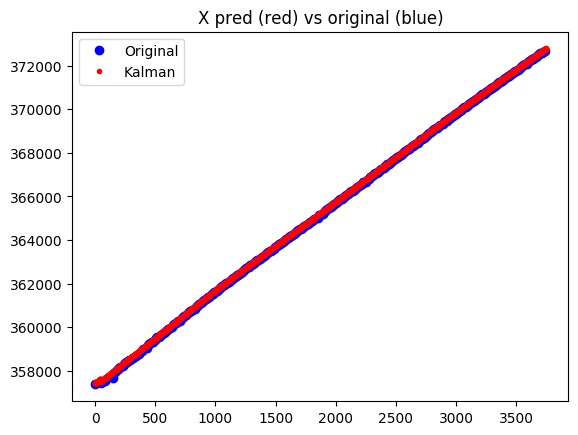

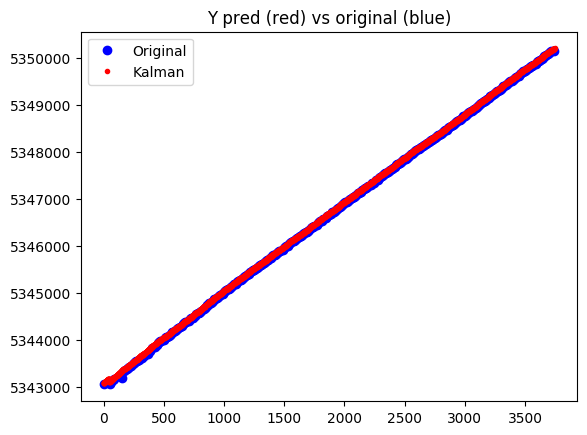

In [73]:
X_samp_pred, Y_samp_pred, X_samp_orig, Y_samp_orig, _, _, _,_, Kalman_observed_sec = myKalman(df_sampled, R,Q,P_k)

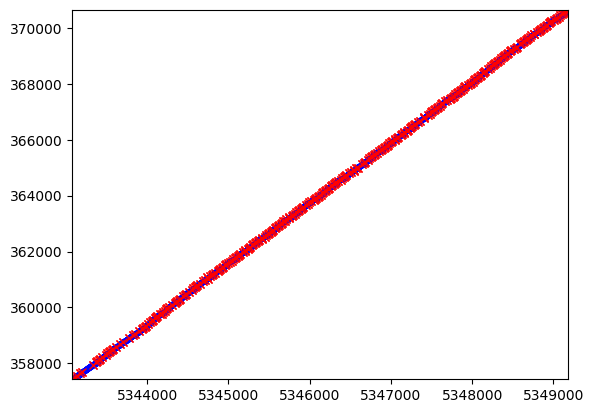

In [74]:
X_samp_pred = np.array(X_samp_pred)
Y_samp_pred = np.array(Y_samp_pred)
X_samp_orig = np.array(X_samp_orig)
Y_samp_orig = np.array(Y_samp_orig)

closer_look = np.arange(0,3200,1)
plt.plot(X_samp_pred[closer_look], Y_samp_pred[closer_look], "b.")
plt.plot(X_samp_orig, Y_samp_orig, "rx")

plt.plot(X_samp_pred ,Y_samp_pred, "b.")
plt.plot(X_samp_orig, Y_samp_orig, "rx")

plt.xlim(min(X_samp_pred[closer_look]),max(X_samp_pred[closer_look]))
plt.ylim(min(Y_samp_pred[closer_look]),max(Y_samp_pred[closer_look]))

plt.show()

# Kalman Filter Errors:

In [75]:
# # X and Y coordinate errors:
# X_error = X_samp_orig[2:len(X_samp_orig)] - X_samp_pred[realSpdCount]
# Y_error = Y_samp_orig[2:(len(X_samp_orig))] - Y_samp_pred[realSpdCount]

# Euclidian_error = np.sqrt(X_error**2 + Y_error**2)
# plt.plot(realSpdCount,X_error,'.')
# plt.plot(realSpdCount,Y_error,'.')
# plt.plot(realSpdCount,Euclidian_error,'.')

# legend_lab = ["X-error","Y-error","Euclidian distance error"]
# plt.legend(legend_lab, loc = "best")
# plt.title("Kalman errors")
# plt.show()

# print('\n\n')
# print("MSE X error", np.sum(X_error**2)/len(X_error))
# print()
# print("MSE Y error", np.sum(Y_error**2)/len(X_error))
# print()
# print("Average Euclidian error:",np.sum(Euclidian_error)/len(X_error) )

# Linear Implementation

### This will be a function of time
We will be estimating X Y SpeedOverGround CourseOverGround. With this we can calculate the speed in the X and Y axis respectively.

#### Idea:
$X_{new} =  X_{old} + Speed_{x-axis} \times time$

$Y_{new} =  Y_{old} + Speed_{y-axis} \times time$


## Dataframe just for Linear

In [76]:
df_mmsi = copy.deepcopy(pd_dataset_new)

# Import the linear regression model from Scikit learn

In [77]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [78]:
def AIS_linear(df_in, lin_remember_history):
    '''
        df_in:  Pandas Data Frame,
                AIS data frame with more or less linear trajectory
        lin_remember_history: integer,  (default = 5)
                This integer value should specify the number of historical observations the linear method 
                are based on
    '''
    #REMEMBER HISTORY OF MODEL
    remember_history = lin_remember_history 
    
    # Extracting the values from the dataframe
    X_have = df_in['long'].values
    Y_have = df_in['lat'].values
    time = df_in['datetimestamp'].values.astype(int) #exctracting time as an array
    #Extracting speed
    speed = df_in['sog'].values
    course = df_in['cog'].values
    
    
    #Intitial parameters
    current_course = course[0] #initial course value. It remains constant only update if a new value comes
    
    #Time range in seconds
    sec_range = np.arange(0,int(max(time))+1,1)
    
    sec_observed = [] # to rememember when a second was an observed second

    
    #To save historical times
    time_history = np.array([]) # thislist will keep track of the last times recorded, intitial time == 0
    speed_history = np.array([]) # this list keep track of the speeds recorded
    pred_speed = np.array([]) # this list stores the predicted values

    #Speed in X Y
    pred_speedX =  []
    pred_speedY = []
    orig_speedX = []
    orig_speedY = []

    #Saving prediction
    speed_pred = []

    # Saving the X and Y predictions
    X_loc_pred = []
    Y_loc_pred = []
    
    # Setting initial values
    X_new =  X_have[0]
    Y_new = Y_have[0]
    X_error = 0
    Y_error = 0


    #Initial Regression guess with a speed of 4.8, just a random speed value nothing special about it
    reg = LinearRegression()
    reg.fit(np.array([0]).reshape(-1,1),np.array([4.8]).reshape(-1,1))

    #counting the entries to appropriatly measure difference
    counter_sec = 0 
    for sec in sec_range:    
        '''IF WE OBSERVE the value'''

        if(time[counter_sec] == sec):
            sec_observed.append(sec) #We observed index at this second

            if len(time_history) > remember_history : #if the list is long enough
                speed_history = np.delete(speed_history,0) #remove 1st entry in array
                time_history = np.delete(time_history,0) # remove 1st entry in array

            #Saving the last moments up to specified history amount    
            time_history = np.append(time_history,sec)
            speed_history = np.append(speed_history,speed[counter_sec])
            current_course =  course[counter_sec]

            #Fit a new model
            reg = LinearRegression()
            reg.fit(time_history.reshape(-1,1),speed_history.reshape(-1,1))

            #PREDICTING SPEED
            predict_speed_value = reg.predict(np.array([sec]).reshape(-1,1))
            pred_speed = np.append(pred_speed,predict_speed_value)

            #SPEED IN X AN Y AXIS
            pred_X_axis_speed = predict_speed_value[0][0]*np.cos(current_course)
            pred_speedX.append(pred_X_axis_speed)   
            pred_Y_axis_speed = predict_speed_value[0][0]*np.sin(current_course)
            pred_speedY.append(pred_Y_axis_speed)

            # SAVING ORIGINAL VALUES
            orig_speedX.append(speed[counter_sec]*np.cos(course[counter_sec]))
            orig_speedY.append(speed[counter_sec]*np.sin(course[counter_sec]))

            #PREDICTING MOVEMENT IN X AND Y
            X_new = X_new + pred_X_axis_speed
            X_error = X_have[counter_sec] - X_new  # to update next position to the correct spot c
            X_loc_pred.append(X_new)

            Y_new = Y_new + pred_Y_axis_speed
            Y_error = Y_have[counter_sec] - Y_new  # to update next position to the correct spot c
            Y_loc_pred.append(Y_new)

            #Counter to walk through list
            counter_sec += 1   
        else:
            #JUST PERDICT
            predict_speed_value = reg.predict(np.array([sec]).reshape(-1,1))
            #SPEED
            pred_speed = np.append(pred_speed, predict_speed_value)
            #SPEED IN X AN Y AXIS 
            pred_X_axis_speed = predict_speed_value[0][0]*np.cos(current_course)
            pred_speedX.append(pred_X_axis_speed)   
            pred_Y_axis_speed = predict_speed_value[0][0]*np.sin(current_course)
            pred_speedY.append(pred_Y_axis_speed)

            #PREDICTING MOVEMENT IN X AND Y
            X_new = X_new + pred_X_axis_speed + X_error
            X_error = 0 #reset the error after the correction

            Y_new = Y_new + pred_Y_axis_speed + Y_error
            Y_error = 0 #reset the error after the correction
            
            Y_loc_pred.append(Y_new)
            X_loc_pred.append(X_new)




    # PLOTTING - Functions
    plt.plot(sec_range,pred_speed,'r-')
    plt.plot(time,speed,"b-")
    legend_data = ["Linear Method", "Original Data"]
    plt.legend(legend_data,loc = 'best')
    plt.title("Linear method tracking speed")
    plt.ylabel("SOG")
    plt.xlabel("Time")
    plt.show()

    #print(pred_speedX)
    plt.plot(sec_range,np.array(pred_speedX),'r-')
    plt.plot(time,np.array(orig_speedX),'b-')
    legend_data = ["Linear Method", "Original Data"]
    plt.legend(legend_data,loc = 'best')
    plt.title("Speed in X-axis tracking")
    plt.ylabel("SOG")
    plt.xlabel("Time")
    plt.show()


    plt.plot(sec_range,np.array(pred_speedY),'r-')
    plt.plot(time,np.array(orig_speedY),'b-')
    legend_data = ["Linear Method", "Original Data"]
    plt.legend(legend_data,loc = 'best')
    plt.title("Speed in Y-axis tracking")
    plt.ylabel("SOG")
    plt.xlabel("Time")
    plt.show()

    plt.plot(sec_range,np.array(X_loc_pred),'b-')
    plt.plot(time,X_have,'r-')
    legend_data = ["Linear Method", "Original Data"]
    plt.legend(legend_data,loc = 'best')
    plt.title("Y-axis tracking")
    plt.ylabel("SOG")
    plt.xlabel("Time")
    plt.show()

    plt.plot(sec_range,np.array(Y_loc_pred),'b-')
    plt.plot(time,Y_have,'r-')
    legend_data = ["Linear Method", "Original Data"]
    plt.legend(legend_data,loc = 'best')
    plt.title("X-axis tracking")
    plt.ylabel("SOG")
    plt.xlabel("Time")
    plt.show()

    plt.plot(Y_have, X_have,'bx')
    plt.plot(Y_loc_pred,X_loc_pred,'r-')
    legend_data = ["Original Data","Linear Method" ]
    plt.legend(legend_data,loc = 'best')
    plt.title("FINAL RESULT - LINEAR")
    plt.ylabel("SOG")
    plt.xlabel("Time")
    plt.show()   
                
    return np.array(X_loc_pred), np.array(Y_loc_pred), np.array(pred_speed), np.array(sec_observed)

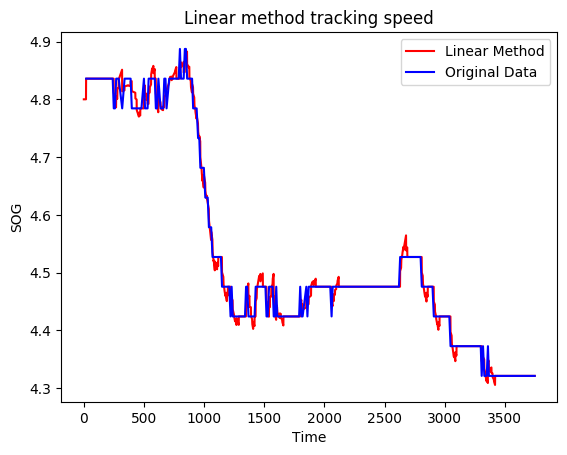

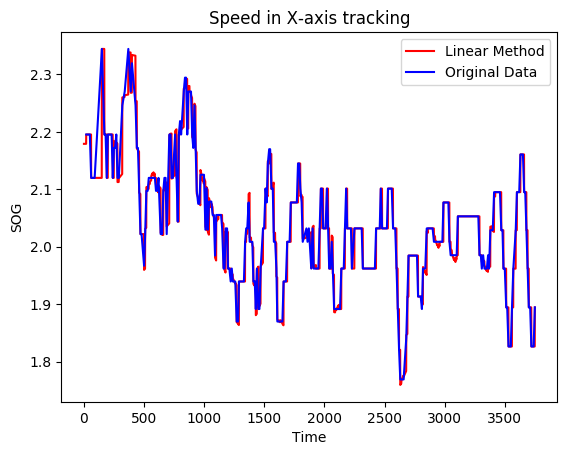

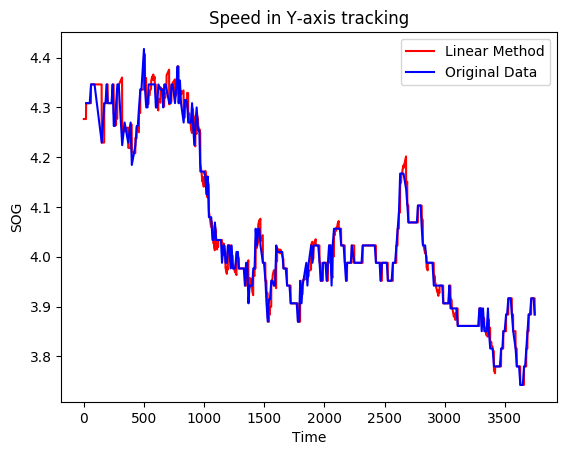

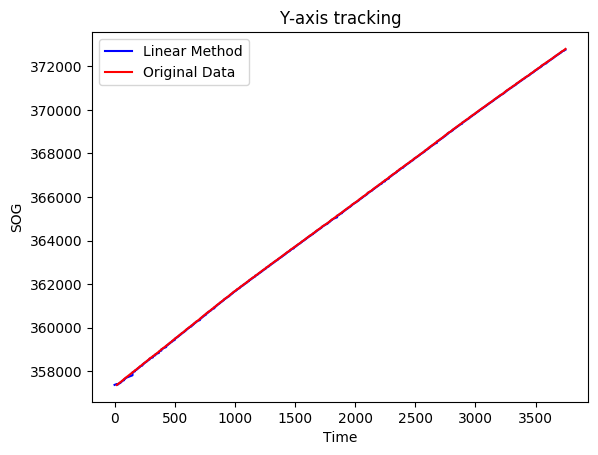

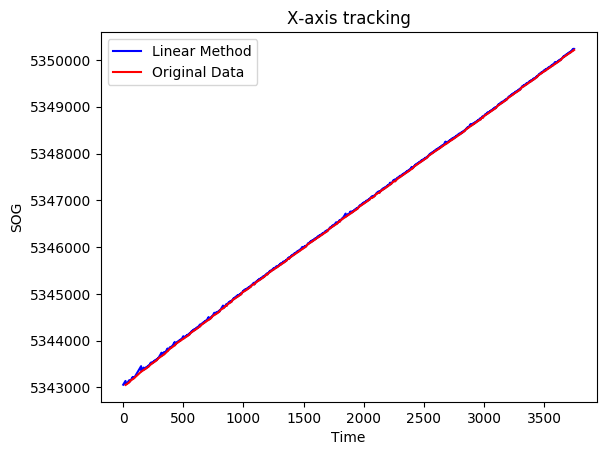

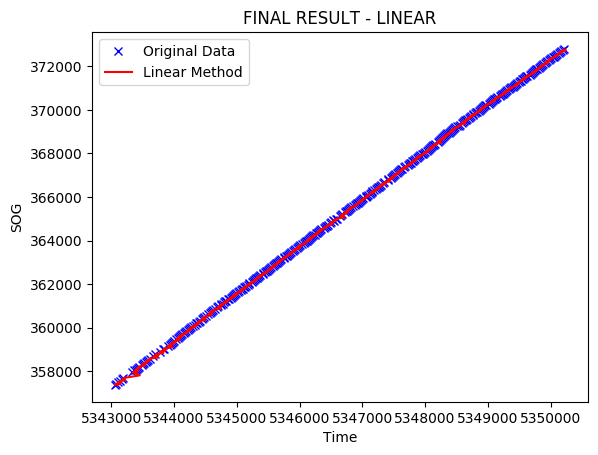

In [79]:
pred_linear_X, pred_linear_Y,pred_linear_SOG, linear_sec_ob = AIS_linear(df_mmsi,5)

In [81]:
def calculate_errors(df_orig,df_sub, pred_X, pred_Y, observed_sec):
    time_steps = df_orig['datetimestamp'].values.astype(int)   
    
    max_time = max(observed_sec)
    time_steps = time_steps[time_steps <= max_time] 
    
    
    X_pred_orig = pred_X[time_steps]
    Y_pred_orig = pred_Y[time_steps]  
    
    test = np.arange(0,len(X_pred_orig),1)
    

    X_orig = df_orig['long'].values[test]  
    Y_orig = df_orig['lat'].values [test] 
    

    
    X_MSE = np.sum((X_orig - X_pred_orig )**2)/len(test)
    Y_MSE = np.sum((Y_orig - Y_pred_orig )**2)/len(test)
    
    Euclid_AVG = np.sum(np.sqrt((X_orig - X_pred_orig)**2 + (Y_orig - Y_pred_orig )**2))/len(test)
    
    
    X_error = X_orig - X_pred_orig
    Y_error = Y_orig - Y_pred_orig 
    Euclid_err = np.sqrt((X_orig - X_pred_orig)**2 + (Y_orig - Y_pred_orig )**2)
    
    plt.plot(time_steps,X_error,'.')
    plt.plot(time_steps,Y_error,'.')
    plt.plot(time_steps,Euclid_err,'.')
    plt.title("Long Lat and total distance error")
    plt.xlabel("Time")
    plt.ylabel("Metres")
    legend_lab = ["X-error","Y-error","Euclidean"]
    plt.legend(legend_lab, loc = "best")
    plt.show()
    
    
    print("X_MSE",X_MSE)
    print("Y_MSE",Y_MSE)
    print("Euclid_AVG",Euclid_AVG)   

In [82]:
# df_origMMSI = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,1)
# df_subMMSI = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,20)


In [83]:
# calculate_errors(df_origMMSI,df_subMMSI,pred_linear_X,pred_linear_Y,linear_sec_ob)

In [84]:
#pred_linear_X, pred_linear_Y,pred_linear_SOG, linear_sec_ob = AIS_linear(df_subMMSI,5)

In [85]:
# X_error = X_have - np.array(X_loc_pred)[time.astype(int)]
# Y_error = Y_have - np.array(Y_loc_pred)[time.astype(int)]
# #X_samp_pred

# XY_error = np.sqrt(X_error**2 + Y_error**2)
# plt.plot(time,X_error,'.')
# plt.plot(time,Y_error,'.')
# plt.plot(time,XY_error,'.')
# plt.title("Long Lat and total distance error")
# plt.xlabel("Time")
# plt.ylabel("Metres")
# legend_lab = ["X-error","Y-error","XY-error Euclidean"]
# plt.legend(legend_lab, loc = "best")
# plt.show()

# print("MSE X error", np.sum(X_error**2)/len(X_error))
# print("MSE Y error", np.sum(Y_error**2)/len(X_error))
# print("MSE:",np.sum(XY_error)/len(X_error) )



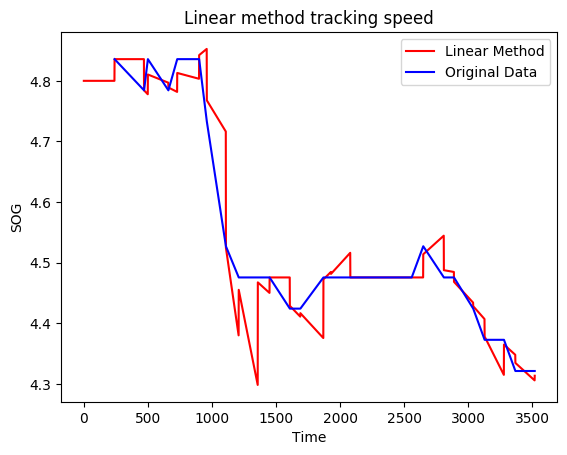

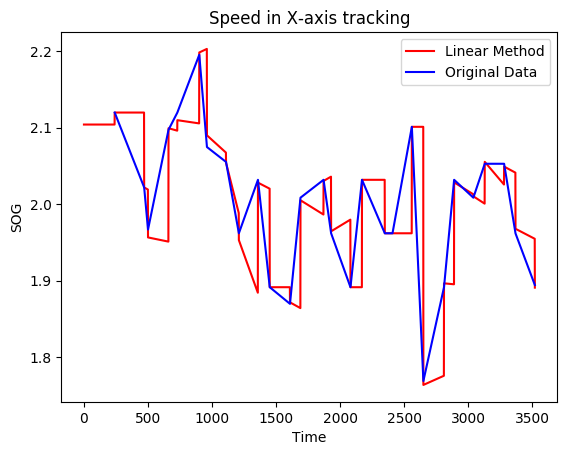

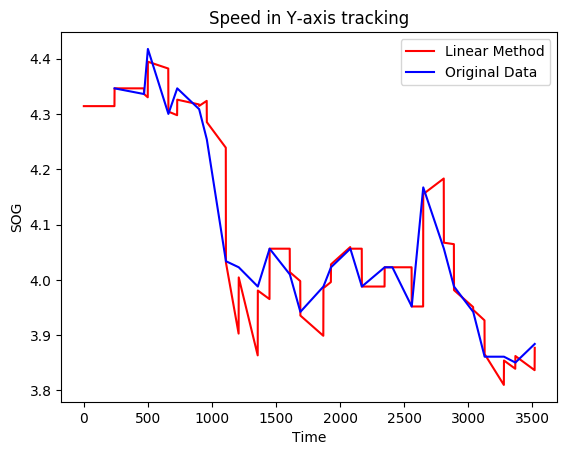

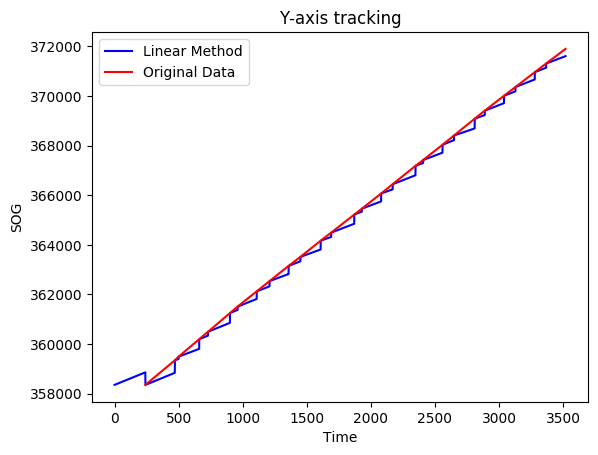

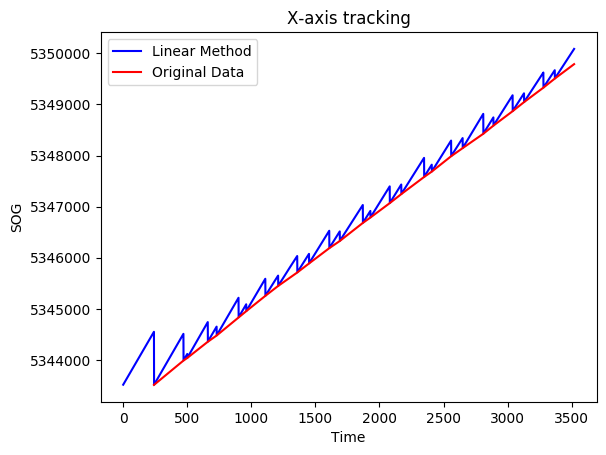

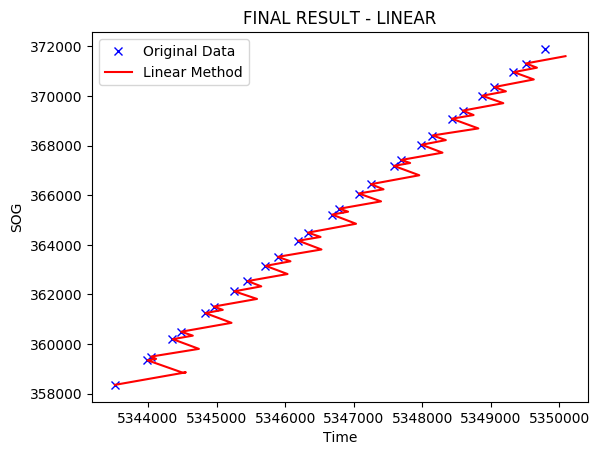

3520
3520
3520
28


In [86]:
pred_linear_X, pred_linear_Y,pred_linear_SOG,linear_sec_ob = AIS_linear(df_subMMSI,2)

print(len(pred_linear_X))
print(len(pred_linear_Y))
print(len(pred_linear_SOG))
print(len(linear_sec_ob))

# Kalman Filter & Linear Funcition

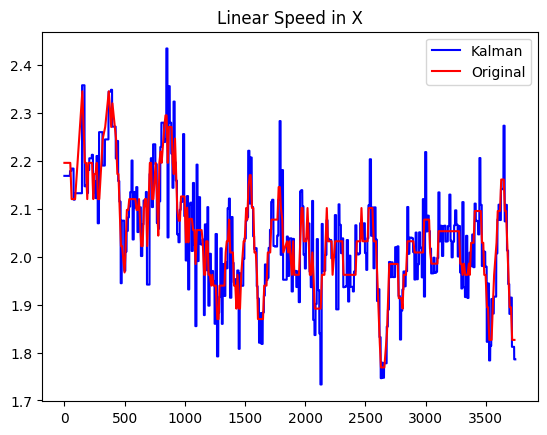

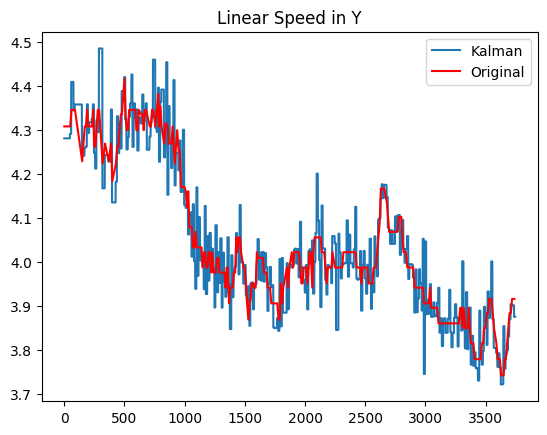

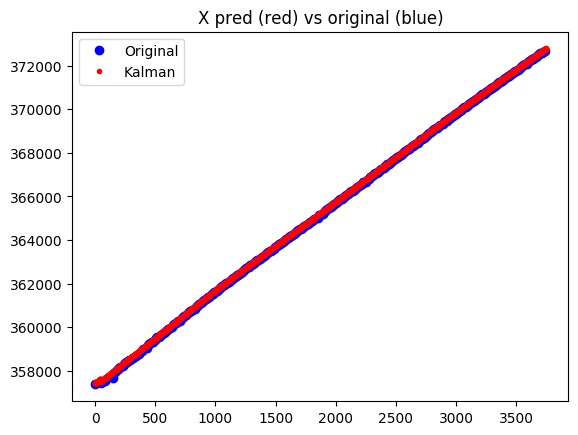

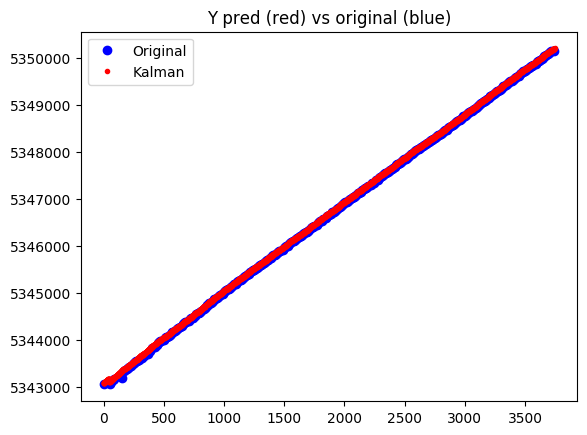

----------------------------------------------------------------------------

----------------------------------------------------------------------------

----------------------------------------------------------------------------

------------------------------------- LINEAR METHOD ---------------------------------------







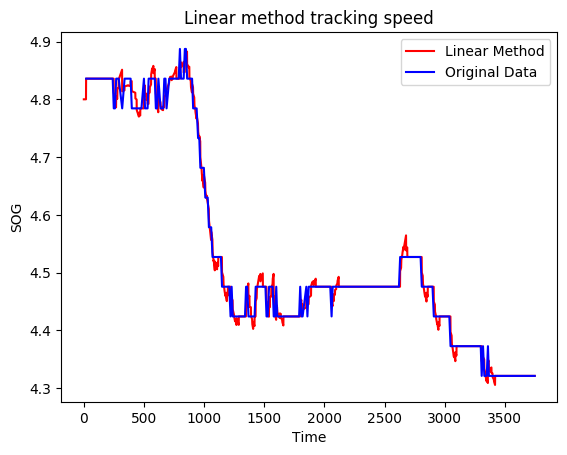

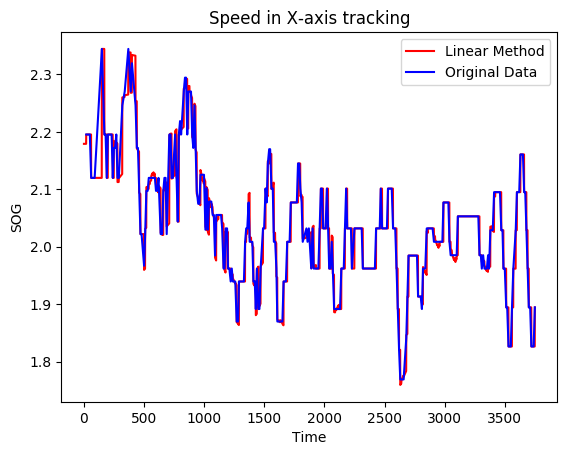

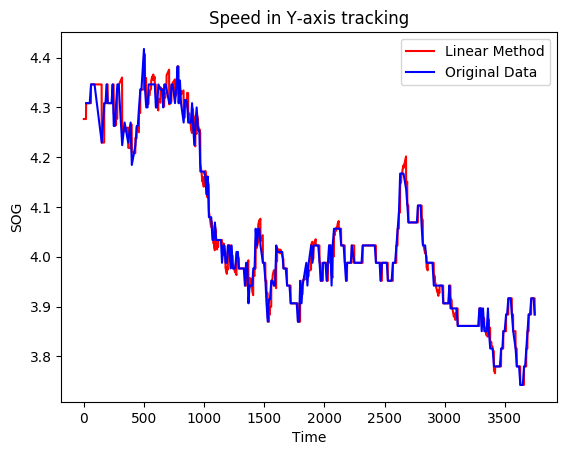

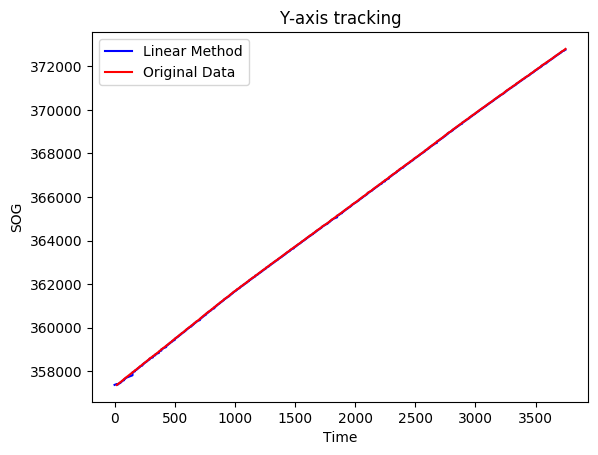

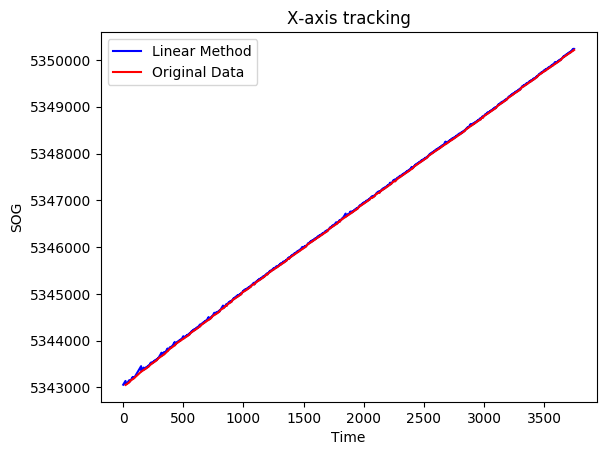

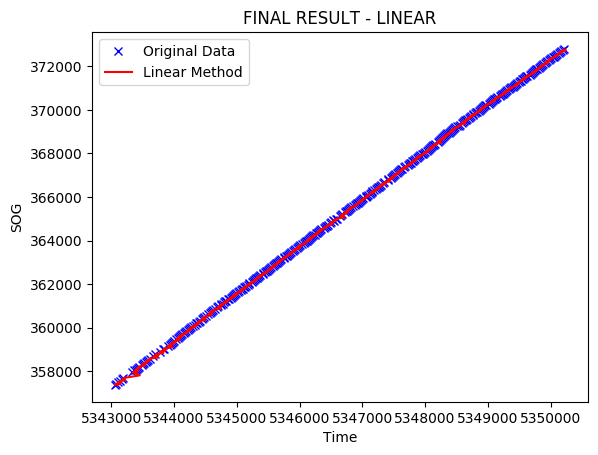

----------------------------------------------------------------------------

----------------------------------------------------------------------------

----------------------------------------------------------------------------

------------------------------------- ERROR  OUTPUT ---------------------------------------







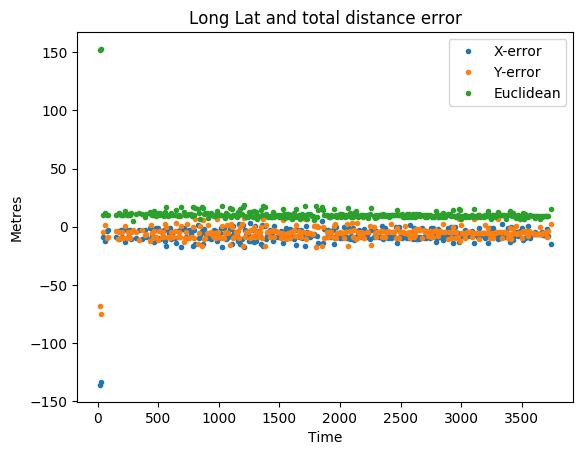

X_MSE 173.01570049192387
Y_MSE 75.8915567768165
Euclid_AVG 11.147618014743225
LINEAR:


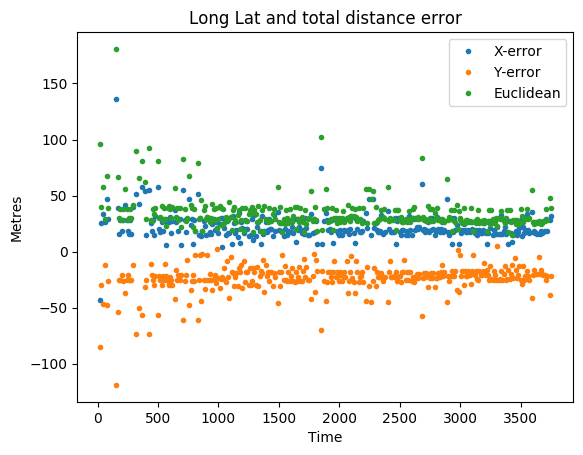

X_MSE 665.1652453422498
Y_MSE 715.4062013870823
Euclid_AVG 34.058362002511906


In [91]:
df_origMMSI = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,1)
df_subMMSI = convert_dataset(pd_dataset.iloc[myrange,:].reset_index(drop = True),240,1)

Kalman_X_pred, Kalman_Y_pred, X_samp_orig, Y_samp_orig, _, _, _,_,Kalman_observed_sec = myKalman(df_subMMSI, R,Q,P_k)

print('----------------------------------------------------------------------------\n')
print('----------------------------------------------------------------------------\n')
print('----------------------------------------------------------------------------\n')
print('------------------------------------- LINEAR METHOD ---------------------------------------')
print('\n\n\n\n')

pred_linear_X, pred_linear_Y,pred_linear_SOG,linear_sec_ob = AIS_linear(df_subMMSI,5)

print('----------------------------------------------------------------------------\n')
print('----------------------------------------------------------------------------\n')
print('----------------------------------------------------------------------------\n')
print('------------------------------------- ERROR  OUTPUT ---------------------------------------')
print('\n\n\n\n')
calculate_errors(df_origMMSI,df_subMMSI,Kalman_Y_pred,Kalman_X_pred,Kalman_observed_sec)
print('LINEAR:')
calculate_errors(df_origMMSI,df_subMMSI,pred_linear_X,pred_linear_Y,linear_sec_ob)


In [88]:
# print('Kalman')
# print(len(Kalman_X_pred))
# print(len(Kalman_Y_pred))
# print("-")
# print(Kalman_observed_sec)

# print('Linear')
# print(pred_linear_X)
# print(pred_linear_Y)
# print(pred_linear_SOG)
# print(linear_sec_ob)

Kalman
3517
3517
-
[   0  500  660  729  900  960 1109 1209 1358 1450 1608 1690 1870 1929
 2080 2170 2348 2408 2559 2649 2810 2889 3039 3128 3279 3368]
Linear
[358357.46657176 358359.57075327 358361.67493477 ... 371599.00890248
 371600.95512336 371602.84146934]
[5343516.09938414 5343520.41359557 5343524.72780699 ... 5350078.18353444
 5350082.00320799 5350085.87079039]
[4.8        4.8        4.8        ... 4.28719766 4.28691984 4.30307968]
[ 240  470  500  660  729  900  960 1109 1209 1358 1450 1608 1690 1870
 1929 2080 2170 2348 2408 2559 2649 2810 2889 3039 3128 3279 3368 3519]
